- 0  pelvis
- 1  left_hip
- 2  right_hip
- 3  spine1
- 4  left_knee
- 5  right_knee
- 6  spine2
- 7  left_ankle
- 8  right_ankle
- 9  spine3
- 10 left_foot
- 11 right_foot
- 12 neck
- 13 left_collar
- 14 right_collar
- 15 head
- 16 left_shoulder
- 17 right_shoulder
- 18 left_elbow
- 19 right_elbow
- 20 left_wrist
- 21 right_wrist

### 개별 파일 애니메이션 저장

In [1]:
# In[1] 기본 설정
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib import format as npformat
from matplotlib.animation import PillowWriter

In [3]:
# In[2] 분석할 파일 경로
path = "D:/HumanML3D-SMPL-main/HumanML3D/new_joints/Msh201.npy"
p = Path(path)
assert p.exists(), f"파일 없음: {p}"
print("OK:", p)

OK: D:\HumanML3D-SMPL-main\HumanML3D\new_joints\Msh201.npy


In [4]:
def safe_load_npy(npy_path: str, mmap: bool = False):
    mmap_mode = "r" if mmap else None
    arr = np.load(npy_path, allow_pickle=False, mmap_mode=mmap_mode)
    return arr

arr = safe_load_npy(path, mmap=False)
type(arr), getattr(arr, "shape", None), getattr(arr, "dtype", None)

(numpy.ndarray, (24, 22, 3), dtype('float32'))

T(frames)=24, J(joints)=22, C=3
global min: -0.28852227330207825
global max: 1.4794483184814453
global mean: 0.32153555750846863

joint range (min/max over all coords & frames):
  range min: 0.15263107419013977
  range max: 1.5435268878936768
  range mean: 1.025504469871521


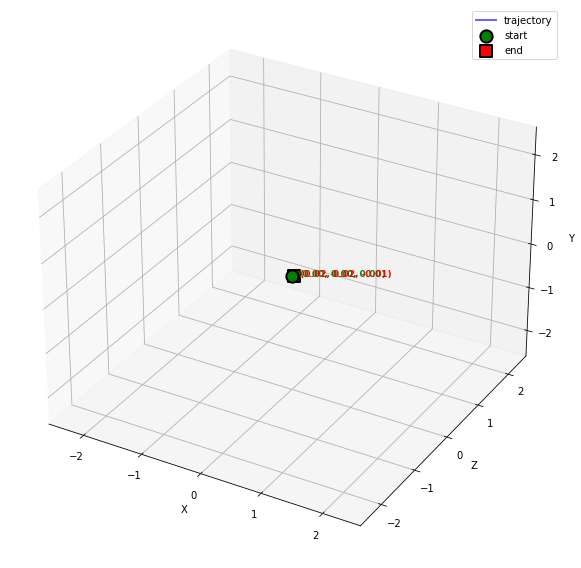

In [5]:
# 모션/관절 포지션 형태 분석: (T, J, 3)
# - 프레임 수(T), 관절 수(J), 좌표 3축
def analyze_TJ3(a: np.ndarray, save_path=None):
    if not (isinstance(a, np.ndarray) and a.ndim == 3 and a.shape[-1] == 3):
        print("이 분석은 (T, J, 3) 배열에만 적용합니다.")
        return

    T, J, C = a.shape
    print(f"T(frames)={T}, J(joints)={J}, C={C}")
    
    # 전체 범위
    print("global min:", float(np.nanmin(a)))
    print("global max:", float(np.nanmax(a)))
    print("global mean:", float(np.nanmean(a)))

    # 관절별 위치 범위(요약)
    joint_min = np.nanmin(a, axis=(0, 2))   # (J,)
    joint_max = np.nanmax(a, axis=(0, 2))
    joint_range = joint_max - joint_min
    print("\njoint range (min/max over all coords & frames):")
    print("  range min:", float(joint_range.min()))
    print("  range max:", float(joint_range.max()))
    print("  range mean:", float(joint_range.mean()))

    # 1번 관절(보통 root/pelvis) 궤적 3D 플롯 (X축 90도 회전 적용)
    root = a[:, 0, :]  # (T,3)
    
    # 첫 프레임의 pelvis를 원점으로 이동
    root_centered = root - root[0]
    
    # X축 90도 회전 함수
    def rotate_x_90(coords):
        """X축 기준 90도 회전"""
        theta = np.deg2rad(90)
        R = np.array([
            [1, 0, 0],
            [0, np.cos(theta), -np.sin(theta)],
            [0, np.sin(theta), np.cos(theta)]
        ])
        return coords.dot(R.T)
    
    # 회전 적용
    root_rotated = rotate_x_90(root_centered)
    #root_rotated = root_centered
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 궤적 선 그리기 (X, Y, Z)
    ax.plot(root_rotated[:, 0], root_rotated[:, 1], root_rotated[:, 2], 
            color='blue', alpha=0.6, label='trajectory', linewidth=2)
    
    # 시작점 (0번째 프레임) - 초록색
    start_x, start_y, start_z = root_rotated[0, 0], root_rotated[0, 1], root_rotated[0, 2]
    ax.scatter(start_x, start_y, start_z, 
            c='green', s=150, marker='o', label='start', zorder=5, 
            edgecolors='black', linewidths=2)
    ax.text(start_x, start_y, start_z, 
            f'  ({start_x:.2f}, {start_y:.2f}, {start_z:.2f})',
            fontsize=9, color='green', weight='bold')
    
    # 끝점 (마지막 프레임) - 빨간색
    end_x, end_y, end_z = root_rotated[-1, 0], root_rotated[-1, 1], root_rotated[-1, 2]
    ax.scatter(end_x, end_y, end_z, 
            c='red', s=150, marker='s', label='end', zorder=5, 
            edgecolors='black', linewidths=2)
    ax.text(end_x, end_y, end_z, 
            f'  ({end_x:.2f}, {end_y:.2f}, {end_z:.2f})',
            fontsize=9, color='red', weight='bold')
    
    # 축 범위 계산
    max_range = max(
        abs(root_rotated[:, 0]).max(),
        abs(root_rotated[:, 1]).max(),
        abs(root_rotated[:, 2]).max()
    )
    
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    #ax.set_xlim(-max_range, max_range)
    #ax.set_ylim(-max_range, max_range)
    #ax.set_zlim(-max_range, max_range)
    
    ax.set_xlim(-2.5, 2.5)
    ax.set_zlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    else:
        plt.show()

analyze_TJ3(arr)

In [6]:
# GIF 애니메이션 생성
jpos = np.load(path)

T, J, _ = jpos.shape

# HumanML3D 관절/뼈대 설정
JOINT_ORDER = [
    "pelvis", "left_hip", "right_hip", "spine1", "left_knee", "right_knee",
    "spine2", "left_ankle", "right_ankle", "spine3", "left_foot", "right_foot",
    "neck", "left_collar", "right_collar", "head", "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow", "left_wrist", "right_wrist"
]
PARENT_MAP = {
    'spine1':'pelvis','spine2':'spine1','spine3':'spine2','neck':'spine3','head':'neck',
    'left_collar':'neck','left_shoulder':'left_collar','left_elbow':'left_shoulder','left_wrist':'left_elbow',
    'right_collar':'neck','right_shoulder':'right_collar','right_elbow':'right_shoulder','right_wrist':'right_elbow',
    'left_hip':'pelvis','left_knee':'left_hip','left_ankle':'left_knee','left_foot':'left_ankle',
    'right_hip':'pelvis','right_knee':'right_hip','right_ankle':'right_knee','right_foot':'right_ankle'
}
bone_pairs = [(JOINT_ORDER.index(p), JOINT_ORDER.index(c))
            for c, p in PARENT_MAP.items()]

# X축 90도 회전 함수
def rotate_x_90(coords):
    """X축 기준 90도 회전"""
    theta = np.deg2rad(90)
    R = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return coords.dot(R.T)

# 첫 프레임의 pelvis 위치를 원점으로 이동
initial_pelvis = jpos[0, 0, :].copy()
jpos_centered = jpos - initial_pelvis[np.newaxis, np.newaxis, :]

# X축 90도 회전 적용
jpos_rotated = np.array([rotate_x_90(frame) for frame in jpos_centered])
#jpos_rotated = jpos_centered

# 전체 모션에 대한 고정된 축 범위 계산 (회전된 데이터 기준)
all_coords = jpos_rotated
x_min, x_max = all_coords[:,:,0].min(), all_coords[:,:,0].max()
y_min, y_max = all_coords[:,:,1].min(), all_coords[:,:,1].max()
z_min, z_max = all_coords[:,:,2].min(), all_coords[:,:,2].max()

# 원점 중심의 정육면체 공간을 위한 최대 범위 계산
max_range = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max), abs(z_min), abs(z_max))

# Figure 설정
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# GIF
writer = PillowWriter(fps=30)

output_path = Path(path).with_suffix('.gif')
with writer.saving(fig, output_path, dpi=200):
    for frame_idx in range(T):
        ax.cla()
        coords = jpos_rotated[frame_idx]
        ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=20)
        for p_idx, c_idx in bone_pairs:
            xs = [coords[p_idx,0], coords[c_idx,0]]
            ys = [coords[p_idx,1], coords[c_idx,1]]
            zs = [coords[p_idx,2], coords[c_idx,2]]
            ax.plot(xs, ys, zs, lw=2)
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')
        
        # 고정된 축 범위 사용
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_zlim(-1.75, 1.75)
        
        writer.grab_frame()

plt.close(fig)
print(f"Saved animation GIF to {output_path}")

Saved animation GIF to D:\HumanML3D-SMPL-main\HumanML3D\new_joints\Msh201.gif


### 폴더 단위 애니메이션 저장

In [7]:
input_folder = Path("D:/HumanML3D-SMPL-main/HumanML3D/new_joints")
output_folder = Path("D:/HumanML3D-SMPL-main/HumanML3D/new_joints_vis")
output_folder.mkdir(exist_ok=True)

npy_files = sorted(input_folder.glob("*.npy"))
total_files = len(npy_files)

# 이미 처리된 파일 확인
existing_plots = {f.stem.replace('_plot', '') for f in output_folder.glob("*_plot.png")}
existing_gifs = {f.stem for f in output_folder.glob("*.gif")}
already_processed = existing_plots & existing_gifs

# 처리할 파일 필터링
files_to_process = [f for f in npy_files if f.stem not in already_processed]

print(f"Total files: {total_files}")
print(f"Already processed: {len(already_processed)}")
print(f"To process: {len(files_to_process)}\n")

# 에러 로그
error_log = []

for idx, npy_file in enumerate(files_to_process, 1):
    sys.stdout.write(f"\rProcessing [{idx}/{len(files_to_process)}]: {npy_file.name}")
    sys.stdout.flush()
    
    path = str(npy_file)
    
    try:
        # 1. 플롯 생성 및 저장 (출력 억제)
        arr = safe_load_npy(path, mmap=False)
        
        # Shape 검증
        if arr.ndim != 3 or arr.shape[-1] != 3:
            error_log.append(f"{npy_file.name}: Invalid shape {arr.shape}")
            continue
            
        save_path = output_folder / f"{npy_file.stem}_plot.png"
        
        import io
        import contextlib
        
        with contextlib.redirect_stdout(io.StringIO()):
            analyze_TJ3(arr, save_path=save_path)
            
        plt.close('all')
        
        # 2. GIF 생성
        jpos = np.load(path)
        T, J, _ = jpos.shape
        
        initial_pelvis = jpos[0, 0, :].copy()
        jpos_centered = jpos - initial_pelvis[np.newaxis, np.newaxis, :]
        jpos_rotated = np.array([rotate_x_90(frame) for frame in jpos_centered])

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        writer = PillowWriter(fps=30)

        output_path = output_folder / f"{npy_file.stem}.gif"
        with writer.saving(fig, output_path, dpi=200):
            for frame_idx in range(T):
                ax.cla()
                coords = jpos_rotated[frame_idx]
                ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=20)
                for p_idx, c_idx in bone_pairs:
                    xs = [coords[p_idx,0], coords[c_idx,0]]
                    ys = [coords[p_idx,1], coords[c_idx,1]]
                    zs = [coords[p_idx,2], coords[c_idx,2]]
                    ax.plot(xs, ys, zs, lw=2)
                ax.set_xlabel('X')
                ax.set_ylabel('Z')
                ax.set_zlabel('Y')
                ax.set_xlim(-2.5, 2.5)
                ax.set_ylim(-2.5, 2.5)
                ax.set_zlim(-1.75, 1.75)
                writer.grab_frame()

        plt.close(fig)
        
    except Exception as e:
        error_log.append(f"{npy_file.name}: {type(e).__name__} - {str(e)}")
        plt.close('all')
        continue

print(f"\n\nAll processed. Output: {output_folder}")

# 에러 로그 출력 및 저장
if error_log:
    print(f"\n\n=== Errors ({len(error_log)} files) ===")
    for err in error_log:
        print(err)
    
    # 에러 로그 파일 저장
    log_file = output_folder / "error_log.txt"
    with open(log_file, 'w') as f:
        f.write('\n'.join(error_log))
    print(f"\nError log saved to: {log_file}")

Total files: 232
Already processed: 0
To process: 232

Processing [232/232]: sp344.npyy

All processed. Output: D:\HumanML3D-SMPL-main\HumanML3D\new_joints_vis
